In [ ]:
import os
import getpass
from uuid import uuid4

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")
os.environ["LANGCHAIN_PROJECT"] = f"Sprint Scribe - {uuid4().hex[0:8]}"

In [85]:
os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY")

In [231]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

loader = CSVLoader(
    file_path=f"../data/TF-Task.csv",
    metadata_columns=[
        "Issue key",
        "Parent key",
        "Parent summary",
        "Summary"
    ],
)

jira_tickets = loader.load()
jira_tickets[0]

Document(metadata={'source': '../data/TF-Task.csv', 'row': 0, 'Issue key': 'TDF-156', 'Parent key': 'TDF-1', 'Parent summary': 'Initiation:Discovery', 'Summary': 'Tailor the customer questionnaire'}, page_content="Description: Using information obtained from the GTM and CSA teams, as well as from the client kick-off meeting, tailor the questionnaire that will be used in the client workshops.\n\nThe goals are:\n\n# Address relevant questions with answers that we already have\n# Reduce the questionnaire to the relevant questions that we don’t already have answers for\n\nThe outcome will be a focused questionnaire that can be used in the discovery workshops when we can confirm the information we already heard, and ask only the relevant remaining questions.  This will let the client know that we’ve been listening to them since the beginning, that the different teams in Infostrux are talking to one another and that we respect the client’s time by not repeating the same set of questions.\n\n

In [232]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind project manager assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

In [233]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4.1-nano")

# Naive Retriever

In [234]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

In [235]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
vectorstore = Qdrant.from_documents(
    jira_tickets,
    embeddings,
    location=":memory:",
    collection_name="LoanComplaints",
)
naive_retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {
        "context": itemgetter("question") | naive_retriever,
        "question": itemgetter("question"),
    }
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
)

In [236]:
response = naive_retrieval_chain.invoke(
    {"question": "How should I structure the project discovery?"}
)
response["context"]

[Document(metadata={'source': '../data/TF-Task.csv', 'row': 1, 'Issue key': 'TDF-17', 'Parent key': 'TDF-1', 'Parent summary': 'Initiation:Discovery', 'Summary': 'Infrastructure Workshop', '_id': '69ed55bf3a78436e9a21284ab3152029', '_collection_name': 'LoanComplaints'}, page_content='Description: As a development team, we want to hold discovery sessions to verify and or adjust the business objectives that were presented in the proposal and to understand the current and desired future data analytics landscape so that we can properly plan out upcoming work\n\n*Notes:*\n\n* More than one session can be scheduled, as necessary.\n* Often, talking directly to stakeholders clarifies what needs to be done. Care has to be taken to understand priorities of different parties and align them if possible, with the priorities set by the person responsible for the whole project\n* Example questions which can be used in some cases instead of the questionnaire for shorter-term projects [https://infostru

# Multi-query Retrieval

In [237]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
)

In [238]:
multi_query_retrieval_chain = (
    {
        "context": itemgetter("question") | multi_query_retriever,
        "question": itemgetter("question"),
    }
    | RunnablePassthrough.assign(context=itemgetter("context"))
)

In [239]:
response = multi_query_retrieval_chain.invoke(
    {"question": "How should I structure the project discovery?"}
)
response["context"]

[Document(metadata={'source': '../data/TF-Task.csv', 'row': 1, 'Issue key': 'TDF-17', 'Parent key': 'TDF-1', 'Parent summary': 'Initiation:Discovery', 'Summary': 'Infrastructure Workshop', '_id': '69ed55bf3a78436e9a21284ab3152029', '_collection_name': 'LoanComplaints'}, page_content='Description: As a development team, we want to hold discovery sessions to verify and or adjust the business objectives that were presented in the proposal and to understand the current and desired future data analytics landscape so that we can properly plan out upcoming work\n\n*Notes:*\n\n* More than one session can be scheduled, as necessary.\n* Often, talking directly to stakeholders clarifies what needs to be done. Care has to be taken to understand priorities of different parties and align them if possible, with the priorities set by the person responsible for the whole project\n* Example questions which can be used in some cases instead of the questionnaire for shorter-term projects [https://infostru

# Emsemble method

In [240]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [
    naive_retriever,
    multi_query_retriever,
]
equal_weighting = [1 / len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

In [241]:
ensemble_retrieval_chain = (
    {
        "context": itemgetter("question") | ensemble_retriever,
        "question": itemgetter("question"),
    }
    | RunnablePassthrough.assign(context=itemgetter("context"))
)

In [242]:
response = ensemble_retrieval_chain.invoke(
    {"question": "How should I structure the project discovery?"}
)
response["context"][0].metadata.get("Parent key")

'TDF-1'

Generate a summary of the JIRA Epics based on the tickets

In [ ]:
import pandas as pd

jira_epics_df = pd.read_csv("../data/TF-EPIC.csv")

# Group all Jira tickets by their 'Parent key' (epic)
from collections import defaultdict

# Build a mapping from epic key to its tickets
epic_tickets = defaultdict(list)
for ticket in jira_tickets:
    parent_key = ticket.metadata.get("Parent key", None)
    if parent_key:
        epic_tickets[parent_key].append(ticket)

# LLM-based epic summary generation
epic_summary_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            (
                "You are an expert at summarizing JIRA epics. "
                "Given the descriptions of all tasks in an epic, generate a concise, high-level summary of the epic. "
                "Return your answer as a single paragraph suitable for an engineering team."
            ),
        ),
        (
            "human",
            (
                "JIRA Task Descriptions:\n{task_descriptions}\n"
                "Summarize the overall epic as described."
            ),
        ),
    ]
)

def get_epic_summary_llm(tickets):
    # Concatenate all ticket descriptions for the epic
    all_descriptions = []
    for ticket in tickets:
        desc = ticket.page_content
        # Try to extract just the Description part if possible
        if "Description:" in desc:
            desc = desc.split("Description:", 1)[1].strip()
        all_descriptions.append(desc)
    all_text = "\n\n".join(all_descriptions)
    prompt = epic_summary_prompt.format_messages(task_descriptions=all_text)
    response = llm(prompt)
    # Just return the LLM's content as the summary
    return response.content.strip()

for index, row in jira_epics_df.iterrows():
    tickets = epic_tickets[row["Issue key"]]
    jira_epics_df.at[index, "Summary"] = get_epic_summary_llm(tickets)

jira_epics_df.to_csv("../data/TF-EPIC.csv", index=False)

In [243]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

loader = CSVLoader(
    file_path=f"../data/TF-EPIC.csv",
    metadata_columns=[
        "Issue key",
        "Summary",
    ],
)

jira_epics = loader.load()
jira_epics[0].metadata.get("Summary")

'This epic encompasses the end-to-end Data Quality Improvement (DQI) lifecycle, starting with a comprehensive understanding of the identified data quality issues through detailed assessment of data, processes, people, and technology environments. It involves defining the business context and impact using quantitative and qualitative measures, conducting root cause analysis with stakeholder engagement, and developing prioritized, documented improvement plans with clear ownership. The epic ensures implementation of corrective and preventive actions, including process changes, controls, training, and monitoring via data quality dimensions and metrics to sustain improvements. Continuous communication and change management are integral throughout to educate stakeholders, maintain executive support, foster a data quality culture, and demonstrate ROI. Ultimately, this work standardizes and institutionalizes data quality practices to prevent recurrence of errors and embed ongoing improvement w

# Generate graph

In [257]:
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.tools.tavily_search import TavilySearchResults
from typing import TypedDict, Annotated, Any
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Assume ensemble_retrieval_chain, llm, jira_epics, and epic_tickets are already defined in the notebook context


# 1. Define the state
class EpicGraphState(TypedDict):
    query: str
    epic_key: str
    epic_summary: str
    epic_tickets: list[Any]
    is_related: bool
    online_results: list[Any]


# 2. Node: Retrieve tickets related to the query
def retrieve_tickets_node(state: EpicGraphState):
    query = state["query"]
    results = ensemble_retrieval_chain.invoke({"question": query})
    return {
        "epic_key": results['context'][0].metadata.get("Parent key") if "context" in results and len(results['context']) > 0 else None
    }

# 3. Node: Get Epic summary for the parent key of the first result
def get_epic_summary_node(state: EpicGraphState):
    epic_key = state["epic_key"]
    if not epic_key:
        return {
            "epic_summary": None
        }

    # Find the epic in jira_epics matching the epic_key and get its summary
    epic_summary = None
    for epic in jira_epics:
        if epic.metadata.get("Issue key") == epic_key:
            epic_summary = epic.metadata.get("Summary")
            break

    return {
        "epic_summary": epic_summary
    }

# 3.1 Node: Validate if query is related to the epic summary
def validate_query_epic_node(state: EpicGraphState):
    query = state["query"]
    epic_summary = state["epic_summary"]
    if not epic_summary:
        return {
            "is_related": False
        }
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are an expert project manager. Given a user query and an epic summary, determine if the query is about the epic. Respond with 'yes' or 'no'."),
        ("human", "Query: {query}\n\nEpic Summary: {epic_summary}\n\nIs the query about this epic?"),
    ])

    llm_input = prompt.format_messages(query=query, epic_summary=epic_summary)
    result = llm(llm_input)
    answer = result.content.strip().lower()

    return {
        "is_related": answer.startswith("yes")
    }

def is_related_to_epic_node(state: EpicGraphState):
    return state["is_related"]

# 4. Node: Extract all tickets for the epic
def extract_tasks_from_epic_node(state: EpicGraphState):
    epic_key = state["epic_key"]
    if not epic_key:
        return {
            "epic_tickets": []
        }
    # Extract all records from jira_epics where the "Parent key" matches the epic_key
    epic_tickets = []
    for epic in jira_tickets:
        if epic.metadata.get("Parent key") == epic_key:
            epic_tickets.append(epic)
    # Build JSON object as specified
    epic_name = None
    # Try to get the epic name from the first ticket's parent summary, or fallback to epic_key
    if epic_tickets:
        epic_name = epic_tickets[0].metadata.get("Parent summary") or epic_tickets[0].metadata.get("Parent key") or epic_key
    else:
        epic_name = epic_key

    tickets_json = []
    for ticket in epic_tickets:
        print(ticket.metadata)
        name = ticket.metadata.get("Summary", "")
        description = ticket.page_content
        tickets_json.append({"name": name, "description": description})

    output_json = [
        {
            "epic_name": epic_name,
            "tickets": tickets_json
        }
    ]

    return {
        "epic_tickets": output_json
    }


# 5. Node: Search online for technologies mentioned in the query
def search_online_node(state: EpicGraphState):
    query = state["query"]
    tavily = TavilySearchResults()
    search_results = tavily.invoke({"query": query})
    return {
        "online_results": search_results
    }

# 6. Node: Use LLM to generate list of epics and tickets from online info
def generate_epics_and_tickets_node(state: EpicGraphState):
    query = state["query"]
    online_results = state.get("online_results", [])
    context = "\n".join([r["content"] for r in online_results if "content" in r])
    prompt_template = """
You are a project analyst. Given a user query and online information about technologies, generate a list of relevant EPICs and tickets that might be needed for a project.

Format the output as a JSON list in the following structure:

[
  {{
    "epic_name": "<Epic Title>",
    "tickets": [
      {{
        "name": "<Task Title>",
        "description": "<Task Description>"
      }},
      ...
    ]
  }},
  ...
]

Only output the JSON list, nothing else.

Query: {query}
Online Information: {context}
"""
    gen_llm = ChatOpenAI(model="gpt-4.1-mini")
    gen_chain = PromptTemplate.from_template(prompt_template) | gen_llm | JsonOutputParser()
    result = gen_chain.invoke({"query": query, "context": context})

    return {
        "epic_tickets": result
    }

# 7. Define the graph
graph = StateGraph(EpicGraphState)

graph.add_node("RetrieveTickets", retrieve_tickets_node)
graph.add_node("GetEpicSummary", get_epic_summary_node)
graph.add_node("ValidateQueryEpic", validate_query_epic_node)
graph.add_node("ExtractTasksFromEpic", extract_tasks_from_epic_node)
graph.add_node("SearchOnline", search_online_node)
graph.add_node("GenerateEpicsAndTickets", generate_epics_and_tickets_node)

# Edges
graph.set_entry_point("RetrieveTickets")
graph.add_edge("RetrieveTickets", "GetEpicSummary")
graph.add_edge("GetEpicSummary", "ValidateQueryEpic")
graph.add_conditional_edges(
    "ValidateQueryEpic",
    is_related_to_epic_node,
    {
        True: "ExtractTasksFromEpic",
        False: "SearchOnline",
    },
)
graph.add_edge("ExtractTasksFromEpic", END)
graph.add_edge("SearchOnline", "GenerateEpicsAndTickets")
graph.add_edge("GenerateEpicsAndTickets", END)

# Compile the graph
epic_graph = graph.compile()

# Example usage:
# result = epic_graph.invoke({"query": "What are the data quality tasks for this project?"})
# print(result)

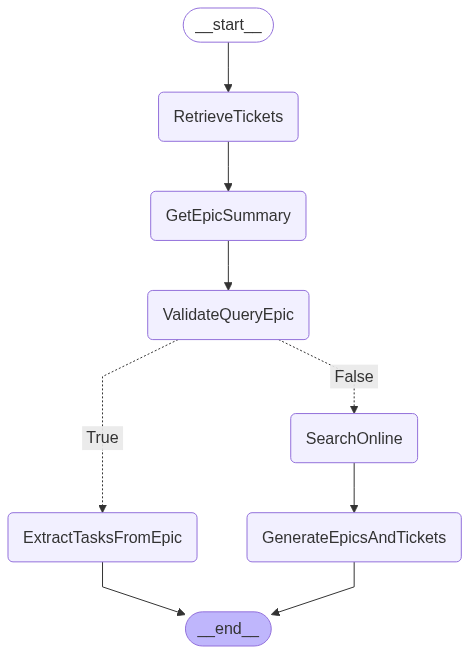

In [179]:
epic_graph

In [258]:
from langchain_core.messages import HumanMessage

# inputs = {
#     "query": "Which discovery task should I do for this project?"
# }
inputs = {
    "query": "Which task should I do for setting Azure Data Factory?"
}

async for chunk in epic_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        if "epic_tickets" in values:
            print(values["epic_tickets"])
        print("\n\n")

Receiving update from node: 'RetrieveTickets'



Receiving update from node: 'GetEpicSummary'



Receiving update from node: 'ValidateQueryEpic'



Receiving update from node: 'SearchOnline'



Receiving update from node: 'GenerateEpicsAndTickets'
[{'epic_name': 'Setup Azure Data Factory Environment', 'tickets': [{'name': 'Create Azure Data Factory instance', 'description': 'Create a new Azure Data Factory resource by selecting subscription, resource group, and region, then review and create the instance.'}, {'name': 'Provision Azure Data Lake Storage accounts', 'description': 'Create source and destination Data Lake storage accounts and set up containers for data movement.'}, {'name': 'Configure networking and access settings', 'description': 'Review and configure networking settings for the Data Factory and storage accounts, including any required IP whitelisting or access rules.'}]}, {'epic_name': 'Design and Build Data Pipeline', 'tickets': [{'name': 'Create Linked Services for sou